In [1]:
## Import libraries
import os
import argparse
import json
import cv2
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.utils import shuffle
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.regularizers import l2, activity_l2
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
import pickle
import csv
import matplotlib.pyplot as plt
%matplotlib inline

# data paths
training_data = 'P3TrainingCenter/driving_log.csv'
udacity_data = '../data/driving_log.csv'
udacity_path_prefix = '../data/IMG/'
recovery_data='../P3RecoveryData/driving_log.csv'
recovery_path='../P3RecoveryData/IMG/'
recovery_data2='../BridgeRecovery/driving_log.csv'
recovery2_path='../BridgeRecovery/IMG/'

#training_path_prefix='../P3Training/IMG/'
centerTraining_Path='P3TrainingCenter/IMG/'
leftTraining_Path='P3TrainingLeft/'
rightTraining_Path='P3TrainingRight/'


Using TensorFlow backend.


In [2]:
#Gather left  right and center images also
f = open(training_data)
driving_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
imagepaths=[]
measurements=[]
correction=0.25
for tokens  in driving_data:
    
    if float(tokens[6])<0.1:
            continue
    for i in range(3):
        nameToken=tokens[i]
        name=nameToken.split('/')[-1]
        if i==0:
            imageName=centerTraining_Path+name
    
        if i==1:
            imageName=leftTraining_Path+name
        if i==2:
            imageName=rightTraining_Path+name

        imagepaths.append(imageName)
    steeringAngle=(float)(tokens[3])
    measurements.append(steeringAngle)
    measurements.append(steeringAngle+correction)
    measurements.append(steeringAngle-correction)
            
        
    '''image=plt.imread(tokens[0])
    plt.imshow(image)
    images.append(image)
    measurements.append(tokens[3])'''
print(len(imagepaths))

print(len(measurements))




21903
21903


In [3]:
f = open(udacity_data)
driving_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

correction=0.25
# add this multiple times...
for tokens  in driving_data[1:]:

    if float(tokens[6])<0.1:
            continue
    for i in range(3):
        nameToken=tokens[i]
        name=nameToken.split('/')[-1]

        imageName=udacity_path_prefix+name
        imagepaths.append(imageName)
    steeringAngle=(float)(tokens[3])
    measurements.append(steeringAngle)
    measurements.append(steeringAngle+correction)
    measurements.append(steeringAngle-correction)
            
        
    '''image=plt.imread(tokens[0])
    plt.imshow(image)
    images.append(image)
    measurements.append(tokens[3])'''
print(len(imagepaths))
print(len(measurements))






46011
46011


In [ ]:
print(len(imagepaths))
print(len(measurements))

img= cv2.imread('P3TrainingLeft/left_2017_02_23_18_03_34_180.jpg')
plt.imshow(img)


In [4]:
def random_distort(img, angle):
    ''' 
    method for adding random distortion to dataset images, including random brightness adjust, and a random
    vertical shift of the horizon position
    '''
    new_img = img.astype(float)
    # random brightness - the mask bit keeps values from going beyond (0,255)
    value = np.random.randint(-28, 28)
    if value > 0:
        mask = (new_img[:,:,0] + value) > 255 
    if value <= 0:
        mask = (new_img[:,:,0] + value) < 0
    new_img[:,:,0] += np.where(mask, 0, value)
    # random shadow - full height, random left/right side, random darkening
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0,w)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:mid,0] *= factor
    else:
        new_img[:,mid:w,0] *= factor
    # randomly shift horizon
    h,w,_ = new_img.shape
    horizon = 2*h/5
    v_shift = np.random.randint(-h/8,h/8)
    pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
    pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(new_img,M,(w,h), borderMode=cv2.BORDER_REPLICATE)
    return (new_img.astype(np.uint8), angle)

59481
../P3RecoveryData/IMG/right_2017_02_25_15_48_12_924.jpg
59481


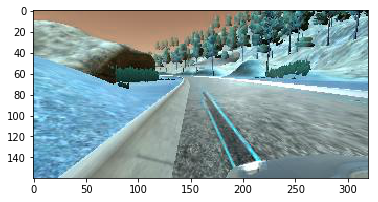

In [5]:
f = open(recovery_data)
driving_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

for i in range (10):
    correction=0.25
    for tokens  in driving_data[1:]:
        
        if float(tokens[6])<0.1:
                continue
        for i in range(3):
            nameToken=tokens[i]
            name=nameToken.split('/')[-1]

            imageName=recovery_path+name
            imagepaths.append(imageName)
        steeringAngle=(float)(tokens[3])
        measurements.append(steeringAngle)
        measurements.append(steeringAngle+correction)
        measurements.append(steeringAngle-correction)


        '''image=plt.imread(tokens[0])
        plt.imshow(image)
        images.append(image)
        measurements.append(tokens[3])'''
print(len(imagepaths))
img=cv2.imread(imagepaths[-2])
plt.imshow(img)
print(imagepaths[-1])
print(len(measurements))






71991
../BridgeRecovery/IMG/right_2017_02_25_16_21_23_657.jpg
71991


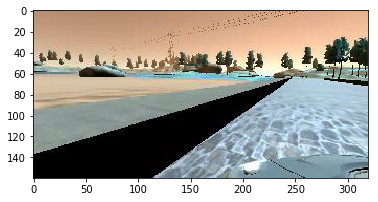

In [6]:
f = open(recovery_data2)
driving_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

for i in range (10):
    correction=0.25
    for tokens  in driving_data[1:]:
        
        if float(tokens[6])<0.1:
                continue
        for i in range(3):
            nameToken=tokens[i]
            name=nameToken.split('/')[-1]

            imageName=recovery2_path+name
            imagepaths.append(imageName)
        steeringAngle=(float)(tokens[3])
        measurements.append(steeringAngle)
        measurements.append(steeringAngle+correction)
        measurements.append(steeringAngle-correction)


        '''image=plt.imread(tokens[0])
        plt.imshow(image)
        images.append(image)
        measurements.append(tokens[3])'''
print(len(imagepaths))
img=cv2.imread(imagepaths[-2])
plt.imshow(img)
print(imagepaths[-1])
print(len(measurements))






In [ ]:
fig, axs = plt.subplots(4,3, figsize=(3, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()


for i, img in enumerate(images[0:12]):
    axs[i].axis('off')
    axs[i].imshow(img)

In [7]:
# Image cropping delimiters
HORIZON=60
BONNET=136

def crop(image):
    """
    Crop the image between the given delimiters for the
    horizon and the bonnet of the car.
    """
    shape = image.shape
    
    cropped = image[HORIZON:BONNET,0:shape[1],:]
    
    return cropped

def resize(image, resize_dim):
    return cv2.resize(image,resize_dim,cv2.INTER_AREA)
#We are using cv2.imread
def convertToYUV(image):
    new_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return new_img



In [8]:
def preProcessImage(image):
    dst=crop(image)
    dst=resize(dst,(64,64))
    dst=convertToYUV(dst)
    return dst
    

In [ ]:
#Validation Images
'''f = open(udacity_data)
validation_Images=[]
validation_Measurements=[]
next(f)
for line in f:
   
    tokens=line.split(',')
        
    nameToken=tokens[0]
    name=nameToken.split('/')[-1]
        
    imageName=udacity_path_prefix+name
    print(imageName)
    image=cv2.imread(imageName)
    plt.imshow(image)
    
    image=preProcessImage(image)
    plt.imshow(image)
    
    validation_Images.append(image)
    steeringAngle=(float)(tokens[3])
    validation_Measurements.append(steeringAngle)'''
            
        
    '''image=plt.imread(tokens[0])
    plt.imshow(image)
    images.append(image)
    measurements.append(tokens[3])'''



In [9]:
print(len(imagepaths))
print(len(measurements))



71991
71991


In [10]:
#flip the images
augmented_images=imagepaths
augmented_measurements=measurements
'''for image,measurement in zip(images,measurements):
    flippedImage=cv2.flip(image,1)
    flippedMeasurement=measurement*-1.0
    flippedImage=preProcessImage(flippedImage)
    augmented_images.append(flippedImage)
    augmented_measurements.append(flippedMeasurement)
    
    image=preProcessImage(flippedImage)

    augmented_images.append(image)
    augmented_measurements.append(measurement)'''
    
    
print(len(augmented_images))
print(len(augmented_measurements))


71991
71991


In [11]:
X_train=np.array(augmented_images)
y_train=np.array(augmented_measurements)

#X_val=np.array(validation_Images)
#y_val=np.array(validation_Measurements)



In [12]:
print(X_train.shape)
print(y_train.shape)

(71991,)
(71991,)


In [13]:
from keras.optimizers import Adam



# Training parameters
learning_rate = 1e-4
number_of_epochs = 7
batch_size = 64
number_of_samples_per_epoch = 20032
validation_split = 0.3

# Images size
resize_x=64
resize_y=64

# Input layer shape
ch, row, col = 3, resize_x, resize_y

# Model definition taken from Nvidia's paper at:
# http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
def nv():
    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(col,row,ch),
            output_shape=(col,row,ch)))
    
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Activation('relu'))
    model.add(Dense(1164))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(1))
    return model

# construct the selected model and print it out
model = nv()
model.summary()
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 32, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 31, 31, 24)    0           activation_1[0][0]               
___________________________________________________________________________________________

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import random
import os
from scipy.ndimage import rotate
from scipy.stats import bernoulli

# CSV column names
COLUMNS = ['center','left','right','steering','throttle','brake','speed']


# Parameters to calculate the steering correction when taking left/right cameras
# https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.fc0drgwk7
offset=1.0
dist=15.0
STEERING_COEFFICIENT = offset/dist * 360/( 2*np.pi)  / 25.0

def random_flip(image, steering_angle, flipping_prob=0.5):
    """
    Randomly flip an image, with a given probability
    """
    if random.random() < flipping_prob:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle

def random_shadows(image):
    """
    Generate a random shadow on the image
    area parameter is a percentage of the total image area
    """
    # Generate a separate buffer
    shadows = image.copy()

    image_area = shadows.shape[0] * shadows.shape[1]
    poly = get_shadow_poly(shadows.shape[0], shadows.shape[1])
    cv2.fillPoly(shadows, np.array([poly]), -1)

    alpha = np.random.uniform(0.6, 0.9)
    return cv2.addWeighted(shadows, alpha, image, 1-alpha,0,image)

def get_shadow_poly(max_x, max_y):
    """
    Get the polygons of a random area delimited between
    max_x, max_y. The polygons generated will either be horizontal
    or vertically aligned with the image, with a random distribution.
    """
    horizontal = np.random.uniform()

    if horizontal < 0.5:
        x1 = random.randint(0, max_x/2)
        y1 = 0
        x2 = random.randint(max_x / 2, max_x)
        y2 = 0
        x3 = random.randint(max_x / 2, max_x)
        y3 = max_y       
        x4 = random.randint(0, max_x/2)
        y4 = max_y
    else:
        x1 = 0
        y1 = random.randint(0, max_y/2)
        x2 = 0
        y2 = random.randint(max_y / 2, max_y)
        x3 = max_x
        y3 = random.randint(max_y / 2, max_y)       
        x4 = max_x
        y4 = random.randint(0, max_y/2)
    
    return [[x1,y1],[x2,y2],[x3,y3], [x4,y4]]

def random_shear(image, steering_angle, shear_range=200):
    """
    Sources: 
    https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
    https://github.com/ksakmann/CarND-BehavioralCloning/blob/master/model.py
    :param image:
        Source image on which the shear operation will be applied
    :param steering_angle:
        The steering angle of the image
    :param shear_range:
        Random shear between [-shear_range, shear_range + 1] will be applied
    :return:
        The image generated by applying random shear on the source image
    """
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return image, steering_angle



def random_brightness(image, median=0.8, dev=0.4):
    """
    Source: http://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
    :param image: the image to enhance.
    :return: the input image with altered brightness
    """
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = median + dev * np.random.uniform(-1.0, 1.0)
    hsv[:,:,2] = hsv[:,:,2]*random_bright

    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb

def generate_new_image(image, steering_angle, resize_dim, do_shear_prob=0.5):
    """
    :param image: the image to augment.
    :param steering_angle: the steering label for this image, will be adjusted accordingly to the augmentation steps taken
    :param do_shear_prob: the probability of performing a random shear transformation on the image
    :return: the augmented image and steering angle
    """

    if random.random() < do_shear_prob:
        image, steering_angle = random_shear(image, steering_angle)

    # image = crop(image)
    # image = resize(image, resize_dim)
    # image = random_shadows(image)

    # image, steering_angle = random_flip(image, steering_angle)

    # image = random_brightness(image)

    return image, steering_angle

# center,left,right,steering,throttle,brake,speed
def get_random_camera_data(csv, index):
    """
    Get one of the left, center or right images together with
    the corresponding(adjusted) steering angle.
    """
    rnd = np.random.randint(0, 3)
    img = csv.iloc[index][COLUMNS.index('center') + rnd].strip()
    angle = csv.iloc[index][COLUMNS.index('steering')]
    
    # Adjust steering based on camera position
    if rnd == COLUMNS.index('left'):
        angle = angle + STEERING_COEFFICIENT
    elif rnd == COLUMNS.index('right'):
        angle = angle - STEERING_COEFFICIENT

    return (img, angle)

def next_batch(samples, batch_size=64):
    """
    Get a random batch of data rows
    """
    random_rows = np.random.randint(0, len(samples), batch_size)
    
    batch = []
    for index in random_rows:
        data = get_random_camera_data(samples, index)
        batch.append(data)

    return batch

def generate_next_batch(samples, resize_dim=(64,64), batch_size=64, augment=True):
    """
    Generator for image, steering angle batches.
    :param samples: set of training samples, as read from the .csv files
    :param resize_dim: images will be resized to these dimensions
    :param batch_size: the size of the batches the generator returns.
    """
    while True:
        X_batch = []
        y_batch = []
        images = next_batch(samples, batch_size)
        for img_file, angle in images:
            image = plt.imread(img_file)
            if augment:
                image, angle = generate_new_image(image, angle, resize_dim)
            else:
                image = crop(image)
                image = resize(image, resize_dim)
            X_batch.append(image)
            y_batch.append(angle)

        yield np.array(X_batch), np.array(y_batch)


In [ ]:
import sklearn
import sklearn.utils
from random import randint

def generateData(X_data,Y_data,batch_size=32):
    print("generator called")
    num_samples = len(X_data)
    while 1: # Loop forever so the generator never terminates
        X_data,y_data= sklearn.utils.shuffle(X_data, Y_data)
        images=[]
        angles= []
        random= randint(0,num_samples-batch_size)
        print (random)
        images=X_data[random:batch_size]
        angles=Y_data[random:batch_size]
        '''for offset in range(0, num_samples, batch_size):
            print("offset is", offset)
            images = X_data[offset:offset+batch_size]
            print("image is",image)
            angles=  y_data[offset:offset+batch_size]
            print("angle is",angle)'''
            
        X_train = np.array(images)
        y_train = np.array(angles)
        print(y_train)
        yield sklearn.utils.shuffle(X_train, y_train)


    
    
    


In [14]:
def generate_training_data(imagepaths, angles, isValidation,batch_size=128):
    '''
    method for the model training data generator to load, process, and distort images, then yield them to the
    model. if 'validation_flag' is true the image is not distorted. also flips images with turning angle magnitudes of greater than 0.33, as to give more weight to them and mitigate bias toward low and zero turning angles
    '''
    images, angles = shuffle(imagepaths, angles)
    X,y = ([],[])
    while True:       
        for i in range(len(angles)):
           
            angle = angles[i]
            img = cv2.imread(images[i])
            img=preProcessImage(img)
            if(isValidation==False):
                img,angle=random_distort(img,angle)
            X.append(img)
            y.append(angle)
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                images, angles = shuffle(images, angles)
            if abs(angle) > 0.33:
                img = cv2.flip(img, 1)
                angle *= -1
                X.append(img)
                y.append(angle)
                if len(X) == batch_size:
                    yield (np.array(X), np.array(y))
                    X, y = ([],[])
                    images, angles = shuffle(images, angles)
           

In [15]:

print(len(X_train))
print(len(y_train))

71991
71991


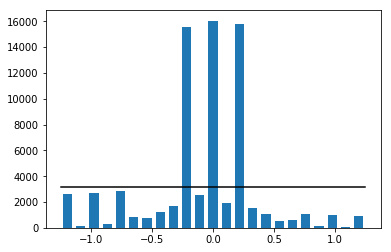

In [16]:

# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 23
avg_samples_per_bin = len(y_train)/num_bins
hist, bins = np.histogram(y_train, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(y_train), np.max(y_train)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()



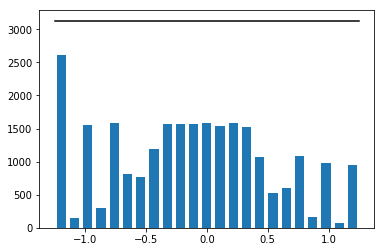

After: (25342,) (25342,)


In [17]:
# determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
# to number of samples above the average, so as to bring the number of samples for that bin down to the average
keep_probs = []
target = avg_samples_per_bin * .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(y_train)):
    for j in range(num_bins):
        if y_train[i] > bins[j] and y_train[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
X_train = np.delete(X_train, remove_list, axis=0)
y_train = np.delete(y_train, remove_list)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(y_train, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(y_train), np.max(y_train)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

print('After:', X_train.shape, y_train.shape)

In [18]:

from sklearn.model_selection import train_test_split
X_train, y_train = shuffle(X_train, y_train)

X_train, X_val, y_train,y_val=train_test_split(X_train,y_train,test_size=0.2)

In [19]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

20273
20273
5069
5069


In [27]:

train_generator = generate_training_data(X_train,y_train,False)
validation_generator= generate_training_data(X_val,y_val,True)



In [28]:
model=nv()

model.compile(optimizer='adam',loss='mse')

history = model.fit_generator(train_generator,
                              
                  samples_per_epoch=1280,
                  nb_epoch=15,
                  validation_data=validation_generator,
                  nb_val_samples=len(X_val),
                  verbose=1)

model.save('mymodel7.h5')

Epoch 1/15
1280/1280 [==============================] - 6s - loss: 0.5626 - val_loss: 0.5552
Epoch 2/15
1280/1280 [==============================] - 4s - loss: 0.5731 - val_loss: 0.5072